<font size="8"> **Plotting results from species distribution models for crabeaters seals** </font>  
We will plot the crabeater seal distribution as predicted by four different species distribution model algorithms:  
1. Generalised Additive Models (GAMs)  
2. Maximum Entrophy Modeling (Maxent)  
3. Random Forests (RFs)  
4. Boosted Regression Trees (BRTs)
  
Additionally, an ensemble prediction is included. The ensemble result is simply the mean probability of the four algorithms listed above.

Given the reported influence on crabeater distribution, plots will include the following information:
- Mean sea ice extent (only the edge will be shown)
- Coontinental shelf 11,000 m depth contor around the Antarctic continent)
- Mean position of the southern boundary of the Antarctic Circumpolar Current (ACC)
  )


Distributions are plotted separately for November and December because environmental conditions differ between these two months, and because they represent two different life stages for crabeaters: breeding period (November) and post-breeding (December).

# Loading libraries

In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))
#Data manipulation and analysis
import xarray as xr
import pandas as pd
import numpy as np
from itertools import cycle
#Spatial data
import geopandas as gp
#Data visualisation
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
#Accessing model data
import cosima_cookbook as cc
#Collection of useful functions developed for this project
import UsefulFunctions as uf
#Dealing with paths to folders/files
from glob import glob
#Parallelising work
from dask.distributed import Client

# Loading Indian sectors mask
Since our area of interest includes the East and Central Indian sectors, we will apply a mask to the data prior to calculating the mean for each variable.

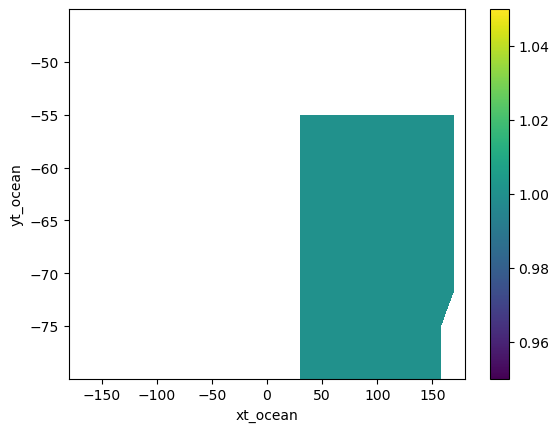

In [2]:
#All variables except velocity
measo = xr.open_dataarray('/g/data/v45/la6889/Chapter2_Crabeaters/MEASO/MEASO_mask.nc')
#Renaming dimensions to match model data
measo = measo.rename({'lat': 'yt_ocean', 'lon': 'xt_ocean'}).sel(yt_ocean = slice(-90, -45))
#Subsetting both masks
measo_ind = xr.where((measo >= 13) & (measo <= 19) & (measo.yt_ocean <= -55), 1, np.nan)
#Checking results
measo_ind.plot()

# Defining output folder

In [2]:
out_folder = '/g/data/v45/la6889/Chapter2_Crabeaters/Mean_conditions_plot'

# Creating a session in the COSIMA cookbook

In [3]:
session = cc.database.create_session()

# Accessing sea ice data from ACCESS-OM2-01
First, we will start a cluster with multiple cores to make analysis faster. Remember the number of CPUs cannot exceed the CPUs you have access to.

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39191/status,
Dashboard: /proxy/39191/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37619,Workers: 7
Dashboard: /proxy/39191/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:42715,Total threads: 1
Dashboard: /proxy/41083/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:36451,


We will now access the model outputs between November 1981 and December 2013 (period of study). For these calculations, we use monthly sea ice concentration outputs from the fourth cycle of ACCESS-OM2-01 (experiment name `01deg_jra55v140_iaf_cycle4`).

In [5]:
#Loading data
var_ice = uf.getACCESSdata_SO('aice_m', '1981-10', '2014-01', freq = '1 monthly', 
                              ses = session, minlat = -80, exp = '01deg_jra55v140_iaf_cycle4',
                              ice_data = True)

#Ensuring data is selected for the time period and area of interest
var_ice = var_ice.sel(time = slice('1981-11', '2013-12'),
                      yt_ocean = slice(-80, -55))

#Transforming longitudes so their range is +/-180 degrees
var_ice = uf.corrlong(var_ice)

#Checking result
var_ice

<xarray.DataArray 'aice_m' (time: 386, yt_ocean: 557, xt_ocean: 3600)>
dask.array<getitem, shape=(386, 557, 3600), dtype=float32, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1981-11-30T12:00:00 ... 2013-12-31T12:00:00
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -55.12 -55.07 -55.01
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

# Calculating mean sea ice extent over study period

In [6]:
#Identifying timesteps to be included in calculations
mean_var = [da for m, da in var_ice.groupby('time.month') if m in [11, 12]]
#Concatenating into single data array, calculate monthly mean over entire time period and apply mask
mean_var = xr.concat(mean_var, dim = 'time').groupby('time.month').mean('time').where(measo_ind == 1, drop = True)
#Checking results
mean_var

<xarray.DataArray 'aice_m' (month: 2, yt_ocean: 557, xt_ocean: 1400)>
dask.array<where, shape=(2, 557, 1400), dtype=float32, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -55.12 -55.07 -55.01
  * xt_ocean  (xt_ocean) float64 30.05 30.15 30.25 30.35 ... 169.8 169.9 170.0
  * month     (month) int64 11 12
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

# Finding sea ice edge
The sea ice edge is the defined as the northernmost areas where sea ice concentration (SIC) is under $10\%$. This is a multistep process:
1. Identify pixels where SIC is greater or equal to 0.1, and change value to 1,
2. Calculate cumulate sum along y axis,
3. Apply mask to remove original `NaN` values from cumulative sums.

This will result in pixels with the highest value along the y axis to be identified as the sea ice edge. 

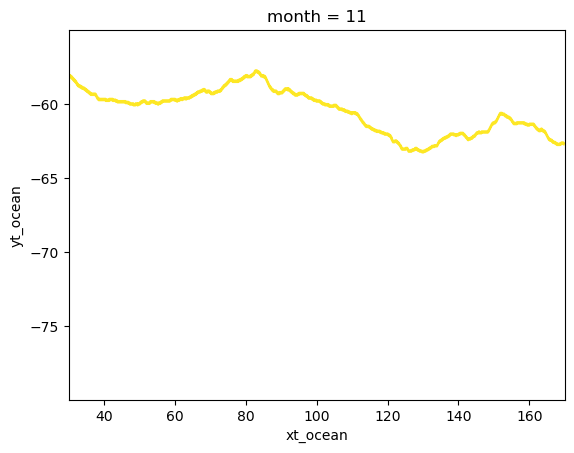

In [7]:
#Assign a value of 1 to any areas where SIC is at least 0.1
ice_10 = xr.where(mean_var >= 0.1, 1, np.nan)

#Adding all cells along y axis. Masking out NA values
ice_10 = ice_10.cumsum(dim = 'yt_ocean', skipna = True).where(~np.isnan(ice_10))

#Finding cells with highest value along y axis. This identifies the ice edge at each longitude.
ice_10 = xr.where(ice_10 == ice_10.max('yt_ocean'), 1, 0).where(~np.isnan(mean_var))

#Checking result for first time step
ice_10.isel(month = 0).plot.contour(levels = [0])

#Saving results
ice_10.to_netcdf(os.path.join(out_folder, 'mean_sea_ice_extent.nc'))

## Loading sea ice edge to avoid calculating again

In [3]:
ice_10 = xr.open_dataarray(os.path.join(out_folder, 'mean_sea_ice_extent.nc'))

# Loading regridded GEBCO bathymetry file
We will load the regridded GEBCO bathymetry that was used to create the bathymetry for the ACCESS-OM2-01 model.

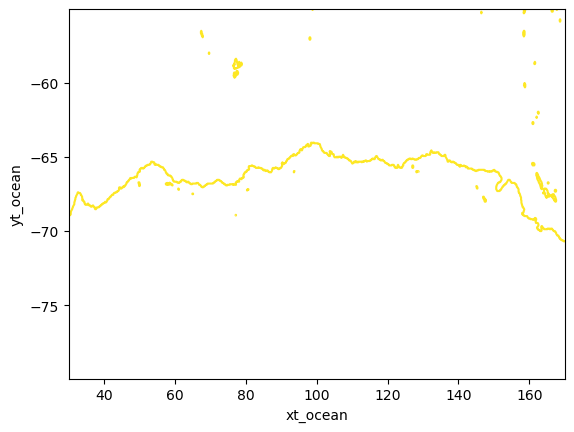

In [9]:
#Loading area data from ACCESS model to use as target grid
area = cc.querying.getvar('01deg_jra55v140_iaf_cycle4', 'area_t', session, n = 1)

#Loading GEBCO bathymetry
bathy = xr.open_dataarray('/g/data/ik11/inputs/access-om2/input_20201102/mom_01deg/topog.nc')

#Assigning coordinate values to replace indices
bathy.coords['xx'] = area['xt_ocean'].values
bathy.coords['yy'] = area['yt_ocean'].values

#Rename coordinate variables so they match model data and subsetting the Southern Ocean
bathy = bathy.rename(({'xx':'xt_ocean', 'yy':'yt_ocean'})).sel(yt_ocean = slice(-80, -55))

#Ensuring longitude values range between +/-180
bathy = uf.corrlong(bathy).where(measo_ind == 1, drop = True)

#Converting to binaty mask
bathy = xr.where(bathy <= 1000, 1, 0).where(~np.isnan(bathy))

#Checking results
bathy.plot.contour(levels = [0])

#Saving results
bathy.to_netcdf(os.path.join(out_folder, 'bathy_1000m.nc'))

## Loading 1000 m depth contour to avoid calculating again

In [4]:
bathy = xr.open_dataarray(os.path.join(out_folder, 'bathy_1000m.nc'))

# Transform ACCESS-OM2-01 grid to dataframe

In [8]:
area_df = bathy.to_dataframe().reset_index()
area_df.drop(columns = 'depth', inplace = True)
area_df = area_df.round({'yt_ocean': 3, 'xt_ocean': 3})
area_df

,yt_ocean,xt_ocean
0,-79.968,30.05
1,-79.968,30.15
2,-79.968,30.25
3,-79.968,30.35
4,-79.968,30.45
...,...,...
779795,-55.010,169.55
779796,-55.010,169.65
779797,-55.010,169.75
779798,-55.010,169.85


In [9]:
#Getting number of times month has to be repeated
rows_month = area_df.shape[0]

#Bind static variables by row
area_df = pd.concat([area_df, area_df], axis = 0)

#Add a month column to bind data frame
area_df['month'] = [11]*rows_month + [12]*rows_month

#Check results
area_df

,yt_ocean,xt_ocean,month
0,-79.968,30.05,11
1,-79.968,30.15,11
2,-79.968,30.25,11
3,-79.968,30.35,11
4,-79.968,30.45,11
...,...,...,...
779795,-55.010,169.55,12
779796,-55.010,169.65,12
779797,-55.010,169.75,12
779798,-55.010,169.85,12


# Predicted distribution ACCESS-OM2-01 matches observations

In [6]:
#Providing location of SDM outputs
mod_match_files = ['../SDM_outputs/GAM/mean_pred_match_obs.csv',
                   '../SDM_outputs/Maxent/Mod_match_obs/reduced_Maxent_model/mean_pred_match_obs.csv', 
                   '../SDM_outputs/RandomForest/Mod_match_obs/mean_pred_match_obs.csv',
                   '../SDM_outputs/BoostedRegressionTrees/Mod_match_obs/mean_pred_match_obs.csv']

#Extracting algorithm name
models = [f.split('/')[2] for f in mod_match_files]

In [14]:
#Loading data frames with predictions
mod_match_obs_df = [uf.df_ready(f, models[i], area_df) for i, f in enumerate(mod_match_files)]
#Create dataset
mod_match_obs = uf.ds_sdm(mod_match_obs_df, bathy)
#Saving dataset
mod_match_obs.to_netcdf(os.path.join(out_folder, 'mod_match_obs.nc'))

## Predicted distribution ACCESS-OM2-01 full suite

In [59]:
mod_files = ['../SDM_outputs/GAM/mean_pred_mod.csv',
             '../SDM_outputs/Maxent/Mod_full/reduced_Maxent_model/mean_pred_ACCESS.csv',
             '../SDM_outputs/RandomForest/Mod_full/mean_pred_ACCESS.csv',
             '../SDM_outputs/BoostedRegressionTrees/Mod_full/mean_pred_ACCESS.csv']

In [60]:
#Loading data frames with predictions
mod_df = [uf.df_ready(f, models[i], area_df) for i, f in enumerate(mod_files)]
#Create dataset
mod = uf.ds_sdm(mod_df, bathy)
#Saving dataset
mod.to_netcdf(os.path.join(out_folder, 'full_mod.nc'))

## Predicted distribution observations

In [63]:
obs_files = ['../SDM_outputs/GAM/mean_pred_obs.csv',
             '../SDM_outputs/Maxent/Obs/reduced_Maxent_model/mean_pred_obs.csv',
             '../SDM_outputs/RandomForest/Obs/mean_pred_obs.csv',
             '../SDM_outputs/BoostedRegressionTrees/Obs/mean_pred_obs.csv']

In [64]:
#Loading data frames with predictions
obs_df = [uf.df_ready(f, models[i], area_df) for i, f in enumerate(obs_files)]
#Create dataset
obs = uf.ds_sdm(obs_df, bathy)
#Saving dataset
obs.to_netcdf(os.path.join(out_folder, 'obs.nc'))

In [ ]:
#Initialise figure
fig = plt.figure(figsize = (8, 13))

#Choosing colorbar
cmap, cmap_r = uf.colourMaps('../../ScientificColourMaps6/', 'batlow')
#Setting levels for colorbar
levels = np.arange(0, 1.1, 0.1)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

#Creating counter for plotting loop
#Defining SDM algorithms
SDM = {'GAM': 'Generalised Additive Model', 
       'Maxent': 'MaxEnt', 
       'RandomForest': 'Random Forest', 
       'BoostedRegressionTrees': 'Boosted Regression Trees',
       'Ensemble': 'Ensemble mean'}

#Defining datasets to be plotted
trained_by = ['ACCESS-OM2-01 (match observations)', 
              'ACCESS-OM2-01 (all variables)', 
              'Observations']

#Merge SDM and datasets
# counter = zip(cycle(trained_by), np.repeat(list(SDM), len(trained_by)))

counter = zip(cycle(np.arange(0, 5)), np.repeat(np.arange(0, 3), 5))
gs = gridspec.GridSpec(nrows = 5, ncols = 3)

########
# #Create composite figure using a grid
# gs = gridspec.GridSpec(nrows = len(SDM)+1, ncols = len(trained_by),
#                        height_ratios = (1, 1, 1, 1, 1, 0.1))
# #Change the width between each plot
# gs.update(wspace = 0.1, hspace = 0.15)

#Initiliase dictionary to store axes
ax = {}

#Creating plot using loop
for i, j in counter:
    ax[i, j] = fig.add_subplot(gs[i, j], projection = projection)
    #Select data based on column index
    if j == 0:
        da = mod_match_obs.November
    elif j == 1:
        da = mod.November
    elif j == 2:
        da = obs.November
    #Plot maps
    p1 = da.isel(model = i).plot.pcolormesh(ax = ax[i, j], colors = cmap_r, 
                                            levels = levels, add_colorbar = False,
                                            transform = ccrs.PlateCarree())
    ice_10.isel(month = 0).plot.contour(levels = [0], colors = 'white', 
                                        ax = ax[i, j], ls = '--',
                                        transform = ccrs.PlateCarree(),
                                       add_colorbar = False)
    bathy.plot.contour(levels = [0], colors = 'red', ax = ax[i, j],
                      transform = ccrs.PlateCarree(), add_colorbar = False)
    # elif coord[0] == 'ACCESS-OM2-01 (match observations)' and coord[1] == 'Ensemble':
    #     p1 = nov_mean.plot.pcolormesh(ax = ax[i], colors = cmap_r, levels = levels,
    #                             transform = ccrs.PlateCarree(), add_colorbar = False)
    #     ice_10.isel(month = 0).plot.contour(levels = [0], colors = 'red', ax = ax[i],
    #                                        transform = ccrs.PlateCarree(),
    #                                        add_colorbar = False)
    #     bathy.plot.contour(levels = [0], colors = 'orange', ax = ax[i],
    #                       transform = ccrs.PlateCarree(), add_colorbar = False)
    # elif coord[0] == 'Observations':
    #     p1 = seasonal_clim_obs[coord[1]].mean('time').plot.pcolormesh(x = 'lon', y = 'lat', ax = ax[i],
    #                               cmap = cmap_r, levels = clim_levels,
    #                               transform = ccrs.PlateCarree(), add_colorbar = False)
    #     SIC_obs[coord[1]].plot.contour(levels = [.15], ax = ax[i], 
    #                                    colors = '#ea11e3',
    #                                    linestyles = 'dashed')
    # elif coord[0] == 'Difference':
    #     p2 = clim_dif[coord[1]].plot.pcolormesh(x = 'lon', y = 'lat', ax = ax[i],
    #                                             cmap = mymap, norm = divnorm, 
    #                                             transform = ccrs.PlateCarree(), 
    #                                             add_colorbar = False)
    # else:
    #     p3 = rmse[coord[1]].plot.pcolormesh(x = 'lon', y = 'lat', ax = ax[i],
    #                                             cmap = cmap_rmse, levels = np.arange(0, 301, 50),
    #                                             transform = ccrs.PlateCarree(), 
    #                                             add_colorbar = False)

#Add land and coastlines
[ax[a].add_feature(land_50m) for a in ax]
[ax[a].coastlines(resolution = '50m') for a in ax]
#Set extent shown in map
[ax[a].set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree()) for a in ax]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

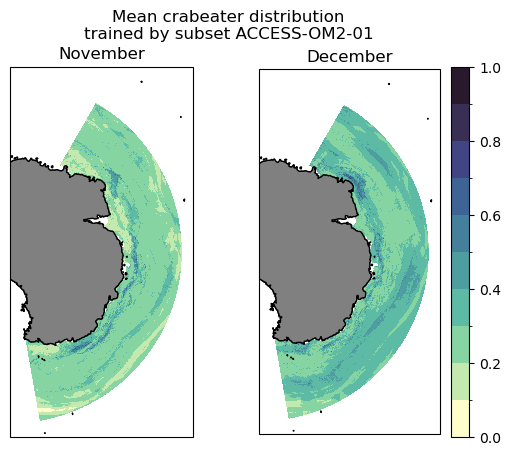

In [9]:
#Initialising figure
fig = plt.figure()

#Getting land mask
land = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                               facecolor = 'gray', linewidth = 0.5)

#Creating projected map
ax1 = fig.add_subplot(1,2,1, projection = ccrs.SouthPolarStereo())

#Setting levels for color palette
levels = np.arange(0, 1.1, 0.1)

#Plotting ensemble for November
da_mean_mod_match_obs.sel(month = 11).plot(ax = ax1, transform = ccrs.PlateCarree(), cmap = cm.cm.deep,
                             levels = levels, add_colorbar = False)
ax1.set_title('November')
ax1.add_feature(land)
ax1.coastlines(resolution = '50m')
ax1.set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree())

#Plotting ensemble for December
ax2 = fig.add_subplot(1,2,2, projection = ccrs.SouthPolarStereo())
da_mean_mod_match_obs.sel(month = 12).plot(ax = ax2, transform = ccrs.PlateCarree(), cmap = cm.cm.deep,
                             levels = levels)
ax2.set_title('December')
ax2.add_feature(land)
ax2.coastlines(resolution = '50m')
ax2.set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree())

#Add figure title
plt.suptitle('Mean crabeater distribution\ntrained by subset ACCESS-OM2-01', y = 1.0)

#Saving figure
plt.savefig('../SDM_outputs/ensemble_distribution_mod_match_obs.png', dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

In [11]:
gams = df_ready(mod_files[0], 'GAM', area_df)
maxent = df_ready(mod_files[1], 'Maxent', area_df)
rf = df_ready(mod_files[2], 'Random Forest', area_df)
brt = df_ready(mod_files[3], 'Boosted Regression Trees', area_df)
mod_pred = pd.concat([gams, maxent, rf, brt])
mod_pred

,yt_ocean,xt_ocean,month,pred,model
0,-71.478,30.05,11,NaN,NaN
1,-71.478,30.15,11,NaN,NaN
2,-71.478,30.25,11,NaN,NaN
3,-71.478,30.35,11,NaN,NaN
4,-71.478,30.45,11,NaN,NaN
...,...,...,...,...,...
996795,-55.010,169.55,12,0.989481,Boosted Regression Trees
996796,-55.010,169.65,12,0.994858,Boosted Regression Trees
996797,-55.010,169.75,12,0.892482,Boosted Regression Trees
996798,-55.010,169.85,12,0.907720,Boosted Regression Trees


In [12]:
da_mod = xr.DataArray(data = mod_pred.pred.values.reshape(8, 356, 1400),
                  dims = ['month', 'yt_ocean', 'xt_ocean'],
                  coords = {'month': [11, 12, 11, 12, 11, 12, 11, 12],
                      'xt_ocean': area.xt_ocean.values,
                           'yt_ocean': area.yt_ocean.values})

#Calculating ensemble (mean of all model predictions)
da_mean_mod = da_mod.groupby('month').mean()

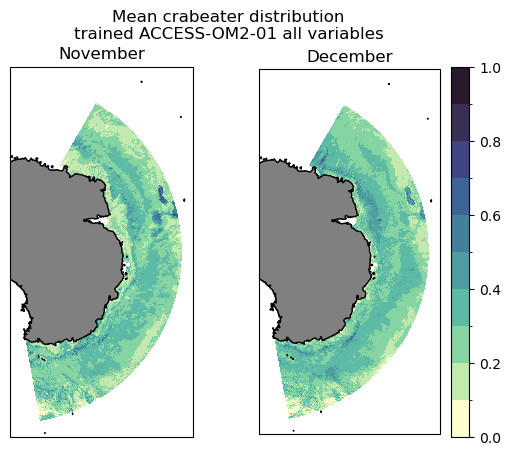

In [13]:
#Initialising figure
fig = plt.figure()

#Getting land mask
land = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                               facecolor = 'gray', linewidth = 0.5)

#Creating projected map
ax1 = fig.add_subplot(1,2,1, projection = ccrs.SouthPolarStereo())

#Setting levels for color palette
levels = np.arange(0, 1.1, 0.1)

#Plotting ensemble for November
da_mean_mod.sel(month = 11).plot(ax = ax1, transform = ccrs.PlateCarree(), cmap = cm.cm.deep,
                             levels = levels, add_colorbar = False)
ax1.set_title('November')
ax1.add_feature(land)
ax1.coastlines(resolution = '50m')
ax1.set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree())

#Plotting ensemble for December
ax2 = fig.add_subplot(1,2,2, projection = ccrs.SouthPolarStereo())
da_mean_mod.sel(month = 12).plot(ax = ax2, transform = ccrs.PlateCarree(), cmap = cm.cm.deep,
                             levels = levels)
ax2.set_title('December')
ax2.add_feature(land)
ax2.coastlines(resolution = '50m')
ax2.set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree())

#Add figure title
plt.suptitle('Mean crabeater distribution\ntrained ACCESS-OM2-01 all variables', y = 1.0)

#Saving figure
plt.savefig('../SDM_outputs/ensemble_distribution_access.png', dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

In [15]:
gams = df_ready(obs_files[0], 'GAM', area_df)
maxent = df_ready(obs_files[1], 'Maxent', area_df)
rf = df_ready(obs_files[2], 'Random Forest', area_df)
brt = df_ready(obs_files[3], 'Boosted Regression Trees', area_df)
obs_pred = pd.concat([gams, maxent, rf, brt])
obs_pred

,yt_ocean,xt_ocean,month,pred,model
0,-71.478,30.05,11,NaN,NaN
1,-71.478,30.15,11,NaN,NaN
2,-71.478,30.25,11,NaN,NaN
3,-71.478,30.35,11,NaN,NaN
4,-71.478,30.45,11,NaN,NaN
...,...,...,...,...,...
996795,-55.010,169.55,12,0.019251,Boosted Regression Trees
996796,-55.010,169.65,12,0.029553,Boosted Regression Trees
996797,-55.010,169.75,12,0.039412,Boosted Regression Trees
996798,-55.010,169.85,12,0.035820,Boosted Regression Trees


In [16]:
da_obs = xr.DataArray(data = obs_pred.pred.values.reshape(8, 356, 1400),
                  dims = ['month', 'yt_ocean', 'xt_ocean'],
                  coords = {'month': [11, 12, 11, 12, 11, 12, 11, 12],
                      'xt_ocean': area.xt_ocean.values,
                           'yt_ocean': area.yt_ocean.values})

#Calculating ensemble (mean of all model predictions)
da_mean_obs = da_obs.groupby('month').mean()

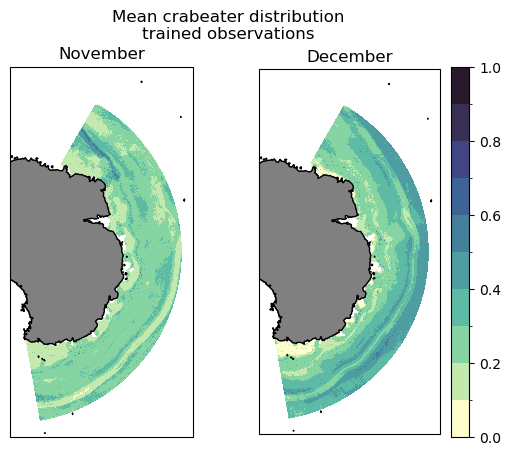

In [17]:
#Initialising figure
fig = plt.figure()

#Getting land mask
land = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                               facecolor = 'gray', linewidth = 0.5)

#Creating projected mpa
ax1 = fig.add_subplot(1,2,1, projection = ccrs.SouthPolarStereo())

#Setting levels for color palette
levels = np.arange(0, 1.1, 0.1)

#Plotting ensemble for November
da_mean_obs.sel(month = 11).plot(ax = ax1, transform = ccrs.PlateCarree(), cmap = cm.cm.deep,
                             levels = levels, add_colorbar = False)
ax1.set_title('November')
ax1.add_feature(land)
ax1.coastlines(resolution = '50m')
ax1.set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree())

#Plotting ensemble for December
ax2 = fig.add_subplot(1,2,2, projection = ccrs.SouthPolarStereo())
da_mean_obs.sel(month = 12).plot(ax = ax2, transform = ccrs.PlateCarree(), cmap = cm.cm.deep,
                             levels = levels)
ax2.set_title('December')
ax2.add_feature(land)
ax2.coastlines(resolution = '50m')
ax2.set_extent([0, 180, -90, -52.5], crs = ccrs.PlateCarree())

#Add figure title
plt.suptitle('Mean crabeater distribution\ntrained observations', y = 1.0)

#Saving figure
plt.savefig('../SDM_outputs/ensemble_distribution_obs.png', dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)